<a href="https://colab.research.google.com/github/amaluvincent/Fake-News-Detection/blob/main/Fake_news_detection_NLP_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Setting up the environment

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk
!pip install tensorflow keras


# 2.Importing libraraies

In [2]:
# import necessary libabaries

import pandas as pd # For data manipulation and handling structured datasets.
import matplotlib.pyplot as plt  # For creating visualizations like plots and charts.
import seaborn as sns  # For advanced and aesthetically pleasing visualizations.
import numpy as np  # For numerical computations and handling arrays/matrices.
from sklearn.pipeline import Pipeline  # For creating a pipeline of machine learning models.
from sklearn.feature_extraction.text import TfidfVectorizer # For combining tokenization, TF-IDF transformation, and vectorization .
from sklearn import feature_extraction, linear_model, model_selection # For feature engineering,linear model and model selection.
from sklearn.model_selection import train_test_split #For splitting data into test and train sets.
from sklearn import metrics # For evaluating the performance of machine learning models.
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report  # For evaluating the performance.
from sklearn.model_selection import cross_val_score # For handling cross validation.
from sklearn.model_selection import GridSearchCV # For evaluating models
from sklearn.linear_model import LogisticRegression # For importing Logistic Regression model.
from sklearn.ensemble import RandomForestClassifier # FOr importing Random forest model.
from sklearn.tree import DecisionTreeClassifier # For importing Decision tree model.
from sklearn.naive_bayes import MultinomialNB  # FOr importing Naive Bayes model.
import string # For handling string operations relevant to text preprocessing.

import nltk  # For working with human language data(text).
nltk.download('stopwords') # Downloads a list of comomn words ("like","the","a","is") called stopwords.
nltk.download('punkt_tab') # Downloads the 'punkt' resource, which is used for tokenization .
nltk.download('wordnet') #For tasks like finding synonyms, antonyms, and understanding the relationships between words.
from nltk.corpus import stopwords  # For accessing the list of stopwords.
from nltk.stem import WordNetLemmatizer  # For reducing words to their base form.
from nltk.tokenize import word_tokenize # FOr splitting text into individual words.
from wordcloud import WordCloud  # FOr creating visual representation of word frequencies.
from collections import Counter # For counting the frequency of items .
import warnings # Importing warning module.
warnings.filterwarnings("ignore") #FOr ignoring warning messages.

from tensorflow.keras.models import Sequential  # For creating a linear stack of layers for LSTM
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional # help the model learn patterns in the text.
from tensorflow.keras.preprocessing.text import Tokenizer # breaking text intoo words
from tensorflow.keras.callbacks import EarlyStopping # tool for preventing overfitting
from tensorflow.keras.preprocessing.sequence import pad_sequences #To maintain uniform length
from sklearn.model_selection import KFold #  For splitting data into training and validation sets for k-fold cross-validation.
from tensorflow.keras.regularizers import l2 # To prevent overfitting by adding penalties to the model's complexity.
from sklearn.utils.class_weight import compute_class_weight # handle  imbalanced dataset


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 3.Load dataset

In [3]:
# Load the ISOT dataset
true_news = pd.read_csv('/content/True.csv')
fake_news =  pd.read_csv('/content/Fake.csv')

# checking the size of each files
print('true:',true_news.shape)
print('fake:', fake_news.shape)


true: (21417, 4)
fake: (23481, 4)


In [4]:
# Display information about the true news dataset
print("True News Dataset Info:")
true_news.info()

# Display information about the fake news dataset
print("\nFake News Dataset Info:")
fake_news.info()


True News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB

Fake News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


# 4. Data cleaning and preparation

In [5]:
# Check for null values in each column of true_news and fake_news
print("Null values in True News dataset:")
print(true_news.isnull().sum())

print("\nNull values in Fake News dataset:")
print(fake_news.isnull().sum())


Null values in True News dataset:
title      0
text       0
subject    0
date       0
dtype: int64

Null values in Fake News dataset:
title      0
text       0
subject    0
date       0
dtype: int64


In [6]:
# Add a label to each dataframe
true_news['label'] = 0   # 0 for legitimate news
fake_news['label'] = 1   # 1 for fake news

# Combine both datasets
df = pd.concat([true_news, fake_news],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # shuffle the data

# Print the combined dataset (first few rows)
print(df.head(5))
print(df.shape)



                                               title  \
0  DEMOCRATS ARE AFRAID That Trump Will Beat Hill...   
1  Nigeria's Senate to probe police brutality all...   
2  China says no excuses for foreign officials me...   
3  Gere faults Trump for blurring meaning of 'ref...   
4  “So Rude!” Nancy Pelosi’s Daughter Blasted By ...   

                                                text       subject  \
0  Don t let Hillary s cheerleaders in the mainst...     left-news   
1  LAGOS (Reuters) - Lawmakers in the upper house...     worldnews   
2  BEIJING (Reuters) - Foreign leaders can t thin...     worldnews   
3  BERLIN (Reuters) - Actor and activist Richard ...  politicsNews   
4                                                         politics   

                 date  label  
0        Apr 25, 2016      1  
1   December 5, 2017       0  
2   October 21, 2017       0  
3  February 10, 2017       0  
4        Dec 18, 2016      1  
(44898, 5)


In [7]:
# Check for missing values after combined
print("Missing values in dataset:\n", df.isnull().sum())

Missing values in dataset:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [8]:
# print dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


In [9]:
# Removing unnecessary column(date)and (title)
df = df.drop(columns=["date", "title"])
print(df.head())

                                                text       subject  label
0  Don t let Hillary s cheerleaders in the mainst...     left-news      1
1  LAGOS (Reuters) - Lawmakers in the upper house...     worldnews      0
2  BEIJING (Reuters) - Foreign leaders can t thin...     worldnews      0
3  BERLIN (Reuters) - Actor and activist Richard ...  politicsNews      0
4                                                         politics      1


In [10]:
# Removing the word "Reuters"(which is the site were true news collected) in the text
df['text'] = df['text'].str.replace('Reuters', '', case=False)
print(df.head(30))


                                                 text       subject  label
0   Don t let Hillary s cheerleaders in the mainst...     left-news      1
1   LAGOS () - Lawmakers in the upper house of Nig...     worldnews      0
2   BEIJING () - Foreign leaders can t think they ...     worldnews      0
3   BERLIN () - Actor and activist Richard Gere sa...  politicsNews      0
4                                                          politics      1
5   This is pretty hysterical and is a reaction du...      politics      1
6   The director of the Anti-LGBT group the Family...          News      1
7   WASHINGTON () - U.S. President Donald Trump is...  politicsNews      0
8   WASHINGTON () - The United States on Friday sa...  politicsNews      0
9   BERLIN () - A leading candidate to be Germany ...     worldnews      0
10  If it wasn t clear before that Donald Trump is...          News      1
11  Donald Trump s insane ways are no longer surpr...          News      1
12         https://www.yo

In [11]:
# Removing the word "Getty images" (which is a visual media company)& "Featured image"in the text
# eg:Print the text before cleaning for the 28th row
print("Before cleaning:")
print(df['text'].iloc[28])

# Perform the cleaning
df['text'] = df['text'].str.replace('Getty Images', '', case=False)
df['text'] = df['text'].str.replace('Featured image', '', case=False)

# Print the text after cleaning for the 28th row
print("\nAfter cleaning:")
print(df['text'].iloc[28])


Before cleaning:
Buckle up. Elizabeth Warren, continuing her crusade for the little guy, wrote a letter to FBI director James Comey over their transparency with Hillary s emails, because they didn t have that same transparency when investigating the big banks. In fact, they usually don t release anything when there s no indictment. They changed their standards for releasing information with Hillary, and Warren wants to know why that same standard can t be used on Wall Street executives. Your recent actions with regard to the investigation of former Secretary of State Hillary Clinton provide a clear precedent for releasing additional information about the investigation of the parties responsible for the financial crisis These new standards present a compelling case for public transparency around the fate of the FCIC referrals. If Secretary Clinton s email server was of sufficient  interest  to establish a new FBI standard of transparency, then surely the criminal prosecution of those re

In [12]:
# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to calculate changes per preprocessing step
def analyze_preprocessing(text):
    if pd.isnull(text) or text.strip() == "":  # Handle NaN or empty string input
        return {
            'Lowercasing Change (%)': 0,
            'Non-Alpha Removed (%)': 0,
            'Stopwords Removed (%)': 0,
            'Lemmatization Changes (%)': 0,
            'Cleaned Text': ''
        }
    # Initial count of tokens
    original_tokens = word_tokenize(text)   # Tokenization
    total_tokens = len(original_tokens)

     # Check if there are no tokens, return 0 for all changes
    if total_tokens == 0:
        return {
            'Lowercasing Change (%)': 0,
            'Non-Alpha Removed (%)': 0,
            'Stopwords Removed (%)': 0,
            'Lemmatization Changes (%)': 0,
        }

    # Step-by-step preprocessing
    lowercased_text = text.lower()    # Lowercasing
    lowercased_tokens = word_tokenize(lowercased_text)    #Tokenization
    alphabetic_tokens = [word for word in lowercased_tokens if word.isalpha()]  #Remove non-alphabetic tokens
    non_stopword_tokens = [word for word in alphabetic_tokens if word not in stop_words]  # Stopword removal
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in non_stopword_tokens]    # Lemmatization

    # Calculate changes as percentages
    #total_tokens = len(original_tokens)
    lowercasing_change = 100 if any(word.isupper() for word in original_tokens) else 0
    non_alpha_removed = (len(lowercased_tokens) - len(alphabetic_tokens)) / total_tokens * 100 if total_tokens > 0 else 0
    stopword_removed = (len(alphabetic_tokens) - len(non_stopword_tokens)) / total_tokens * 100 if total_tokens > 0 else 0
    lemmatization_changes = sum(1 for orig, lemma in zip(non_stopword_tokens, lemmatized_tokens) if orig != lemma) / total_tokens * 100 if non_stopword_tokens else 0

     # Join the lemmatized tokens to form the cleaned text
    cleaned_text = ' '.join(lemmatized_tokens)

    return {
        'Lowercasing Change (%)': lowercasing_change,
        'Non-Alpha Removed (%)': non_alpha_removed,
        'Stopwords Removed (%)': stopword_removed,
        'Lemmatization Changes (%)': lemmatization_changes,
        'Cleaned Text': cleaned_text
    }

# Apply the analysis function to each text in the dataframe and create a new dataframe to store results
df[['Lowercasing Change (%)', 'Non-Alpha Removed (%)', 'Stopwords Removed (%)',
    'Lemmatization Changes (%)','cleaned_text']] = df['text'].apply(lambda x: pd.Series(analyze_preprocessing(x)))

# Display average percentages across all text entries
average_changes = df[['Lowercasing Change (%)', 'Non-Alpha Removed (%)',
                      'Stopwords Removed (%)', 'Lemmatization Changes (%)']].mean()
print("Average Changes across all texts:\n", average_changes)

Average Changes across all texts:
 Lowercasing Change (%)       94.690187
Non-Alpha Removed (%)        13.402350
Stopwords Removed (%)        37.077629
Lemmatization Changes (%)     5.621640
dtype: float64


In [13]:
# Print the original and cleaned text
print(df[['text','cleaned_text','Lowercasing Change (%)', 'Non-Alpha Removed (%)',
          'Stopwords Removed (%)', 'Lemmatization Changes (%)']].head(10))  # Display the first 10 rows

                                                text  \
0  Don t let Hillary s cheerleaders in the mainst...   
1  LAGOS () - Lawmakers in the upper house of Nig...   
2  BEIJING () - Foreign leaders can t think they ...   
3  BERLIN () - Actor and activist Richard Gere sa...   
4                                                      
5  This is pretty hysterical and is a reaction du...   
6  The director of the Anti-LGBT group the Family...   
7  WASHINGTON () - U.S. President Donald Trump is...   
8  WASHINGTON () - The United States on Friday sa...   
9  BERLIN () - A leading candidate to be Germany ...   

                                        cleaned_text  Lowercasing Change (%)  \
0  let hillary cheerleader mainstream medium conv...                     100   
1  lagos lawmaker upper house nigeria parliament ...                     100   
2  beijing foreign leader think get away meeting ...                     100   
3  berlin actor activist richard gere said friday...           

In [14]:
X = df['cleaned_text']
y = df['label']

# Check for duplicates in the input features
print(f"Number of duplicate rows in X: {X.duplicated().sum()}")

# Check for duplicates in the combination of X and y (to consider label alignment)
data = pd.DataFrame({'X': X, 'y': y})
print(f"Number of duplicate rows in combined X and y: {data.duplicated().sum()}")


Number of duplicate rows in X: 6468
Number of duplicate rows in combined X and y: 6467


In [15]:
# Combine X and y into a single DataFrame
data = pd.DataFrame({'X': X, 'y': y})

# Drop duplicates based on both features and labels
data = data.drop_duplicates()

# Separate the cleaned data back into X and y
X = data['X']
y = data['y']

# Print the number of duplicates after cleaning
print(f"Number of duplicate rows in X after cleaning: {X.duplicated().sum()}")
print(f"Number of duplicate rows in combined X and y after cleaning: {data.duplicated().sum()}")


Number of duplicate rows in X after cleaning: 1
Number of duplicate rows in combined X and y after cleaning: 0


In [16]:
# Check for NaN values in 'cleaned_text' after preprocessing
missing_values = df['cleaned_text'].isna().sum()
print(f"Number of NaN values in 'cleaned_text': {missing_values}")


Number of NaN values in 'cleaned_text': 0


# 5.Exploratory Data Analysis

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


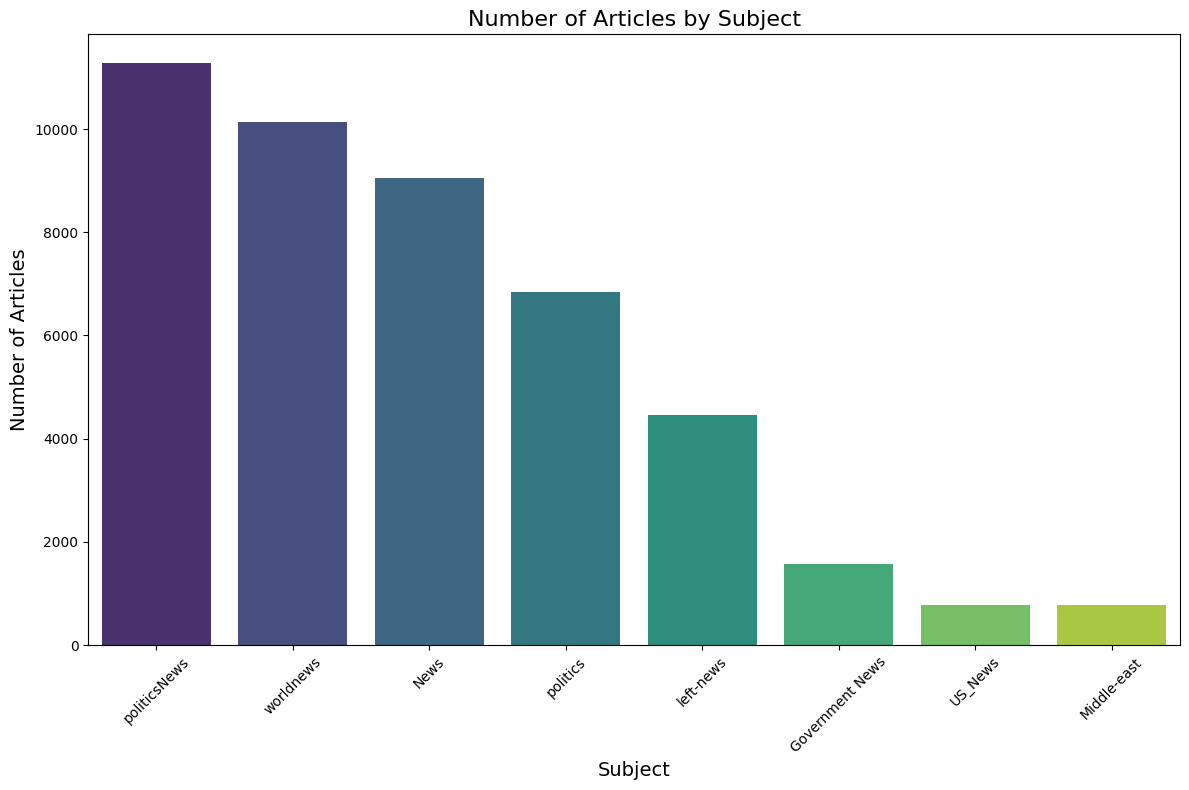

In [17]:
# 5.1 Count the number of articles by subject
subject_counts = df['subject'].value_counts()
print(subject_counts)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')
plt.title('Number of Articles by Subject', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


label
1    23481
0    21417
Name: count, dtype: int64


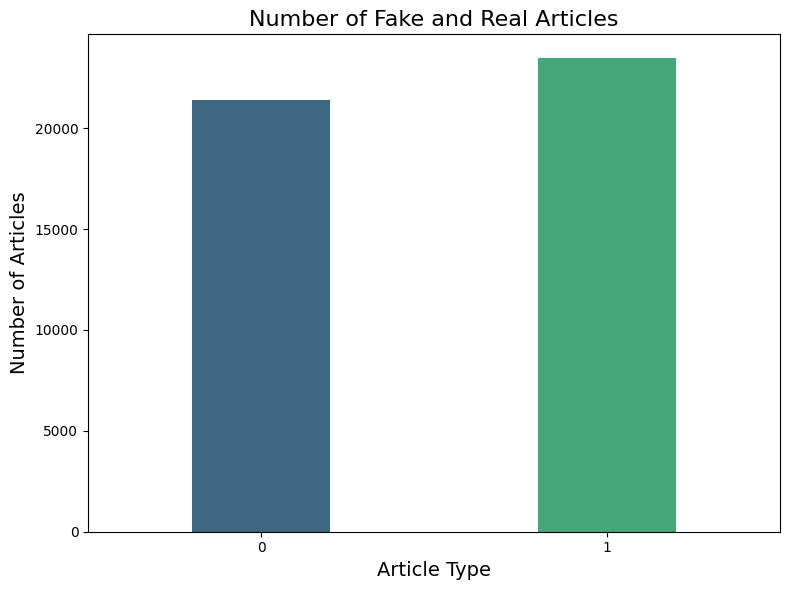

In [18]:
# 5.2 How many fake and real articles?
article_counts = df['label'].value_counts()
print(article_counts)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=article_counts.index, y=article_counts.values,palette='viridis', width=0.4)
plt.title('Number of Fake and Real Articles', fontsize=16)
plt.xlabel('Article Type', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


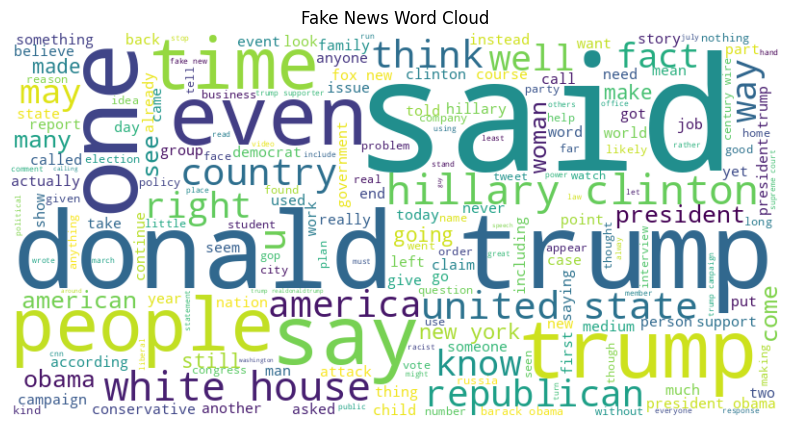

In [19]:
# 5.3 Word cloud for fake news
fake_words = ' '.join(df[df['label'] == 1]['cleaned_text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')
plt.show()

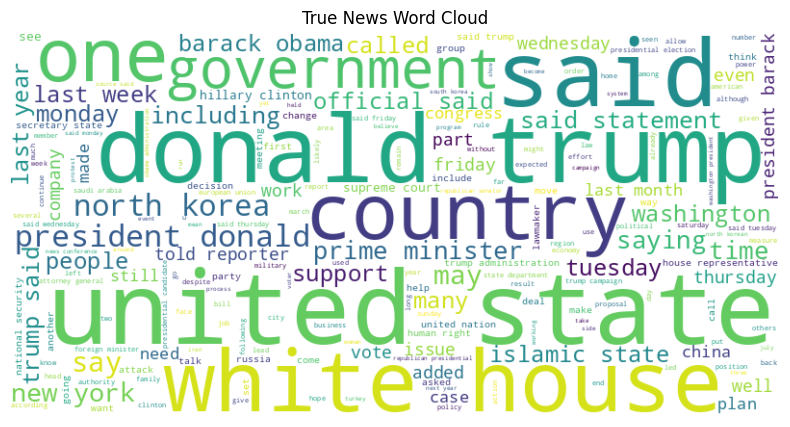

In [20]:
# 5.4 Word cloud for true news
true_words = ' '.join(df[df['label'] == 0]['cleaned_text'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('True News Word Cloud')
plt.show()

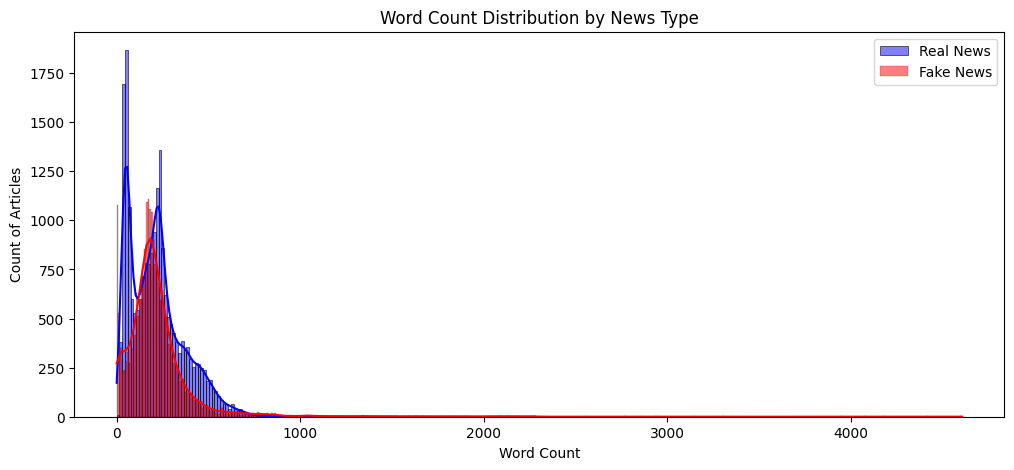

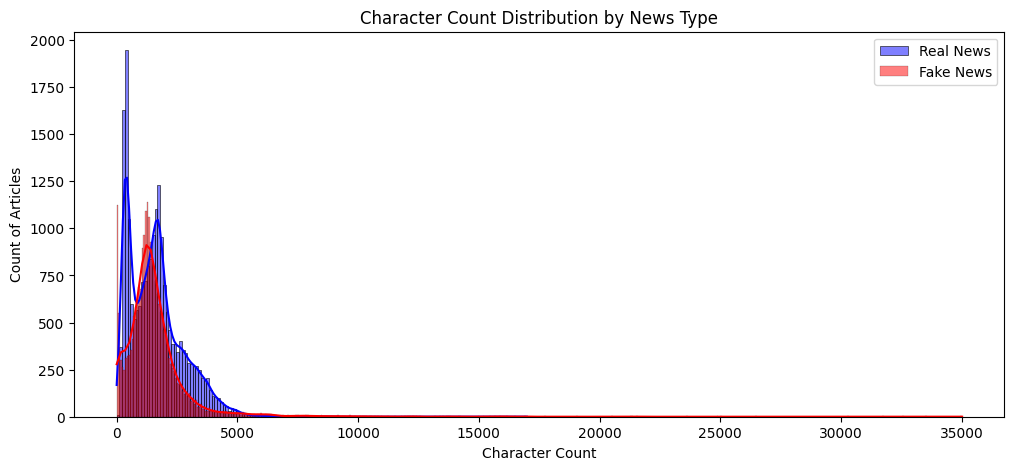

In [21]:
# 5.5 Word count and sentence length analysis
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_text'].apply(len)

# Visualize word and character count distributions
plt.figure(figsize=(12, 5))
sns.histplot(df[df['label'] == 0]['word_count'], color='blue', label='Real News', kde=True)
sns.histplot(df[df['label'] == 1]['word_count'], color='red', label='Fake News', kde=True)
plt.title("Word Count Distribution by News Type")
plt.xlabel("Word Count")
plt.ylabel("Count of Articles")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df[df['label'] == 0]['char_count'], color='blue', label='Real News', kde=True)
sns.histplot(df[df['label'] == 1]['char_count'], color='red', label='Fake News', kde=True)
plt.title("Character Count Distribution by News Type")
plt.xlabel("Character Count")
plt.ylabel("Count of Articles")
plt.legend()
plt.show()

Top 20 words in Fake News: [('trump', 74486), ('said', 31161), ('president', 26391), ('people', 26143), ('one', 23834), ('would', 23462), ('state', 22100), ('clinton', 18733), ('like', 18207), ('obama', 17927), ('time', 17917), ('donald', 17241), ('american', 16099), ('republican', 16076), ('say', 15533), ('also', 15243), ('year', 14887), ('news', 14207), ('new', 14198), ('u', 14184)]
Top 20 words in Real News: [('said', 99037), ('trump', 54280), ('state', 36243), ('would', 31526), ('president', 26939), ('republican', 22098), ('government', 19433), ('year', 18721), ('house', 16906), ('new', 16784), ('also', 15946), ('united', 15576), ('people', 15207), ('party', 14964), ('official', 14575), ('told', 14244), ('country', 13948), ('election', 13910), ('could', 13709), ('one', 13025)]


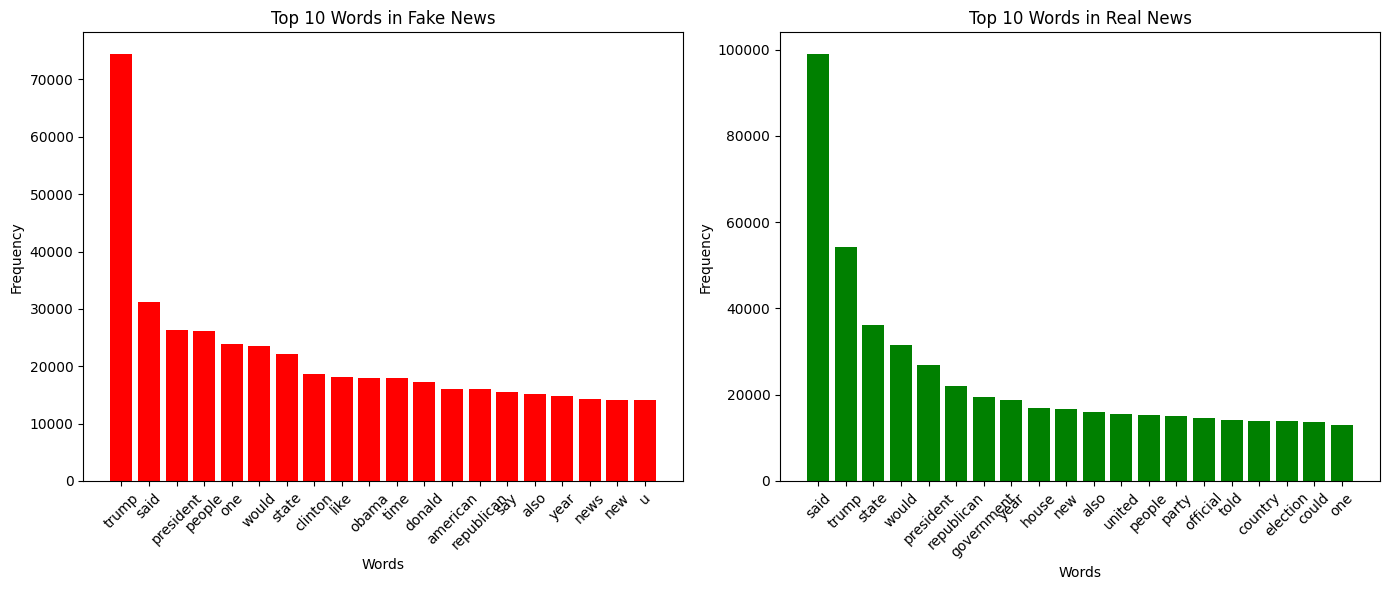

In [22]:
# 5.6 Most  frequent words counter
# Fake News Word Frequency
fake_words = ' '.join(df[df['label'] == 1]['cleaned_text']).split()
counter_fake = Counter(fake_words)  # counting word frequency
top_fake = counter_fake.most_common(20)
print("Top 20 words in Fake News:", counter_fake.most_common(20))

# Real News Word Frequency
real_words = ' '.join(df[df['label'] == 0]['cleaned_text']).split()
counter_real = Counter(real_words)
top_real = counter_real.most_common(20)
print("Top 20 words in Real News:", counter_real.most_common(20))

# Unpack the top words and their counts for fake and real news
fake_words_list, fake_counts = zip(*top_fake)
real_words_list, real_counts = zip(*top_real)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fake News Plot
axes[0].bar(fake_words_list, fake_counts, color='red')
axes[0].set_title('Top 10 Words in Fake News')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Words')
axes[0].set_xticklabels(fake_words_list, rotation=45)

# Real News Plot
axes[1].bar(real_words_list, real_counts, color='green')
axes[1].set_title('Top 10 Words in Real News')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(real_words_list, rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# 6.Training & Testing Data

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Check the shapes of the splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (30744,)
y_train shape: (30744,)
X_test shape: (7687,)
y_test shape: (7687,)


In [24]:
# Check for overlap between training and testing datasets
common_samples = np.intersect1d(X_train, X_test)
print(f"Number of overlapping samples between train and test: {len(common_samples)}")

# Confirm stratification by comparing class distributions
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True))

Number of overlapping samples between train and test: 0
Class distribution in training set:
y
0    0.547391
1    0.452609
Name: proportion, dtype: float64

Class distribution in testing set:
y
0    0.547418
1    0.452582
Name: proportion, dtype: float64


In [25]:
# Removing the common word/ frequent words in both articles to avoid data leakage

# Combine the lists of most frequent words
common_words = set(fake_words_list + real_words_list)

# Function to remove common words from text
def remove_common_words(text):
    return ' '.join([word for word in text.split() if word not in common_words])

# Apply the function to remove common words from training and test sets
X_train = X_train.apply(remove_common_words)
X_test = X_test.apply(remove_common_words)

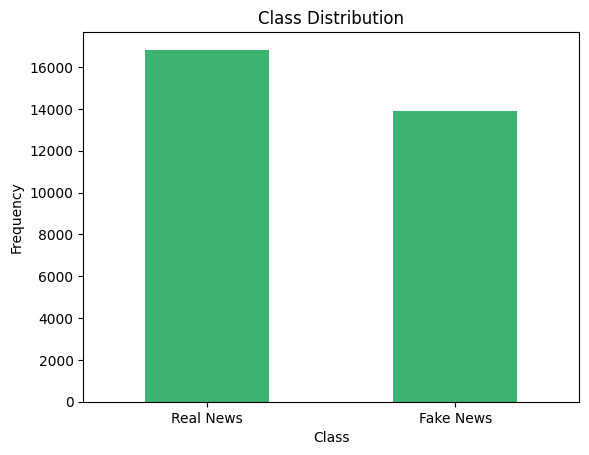

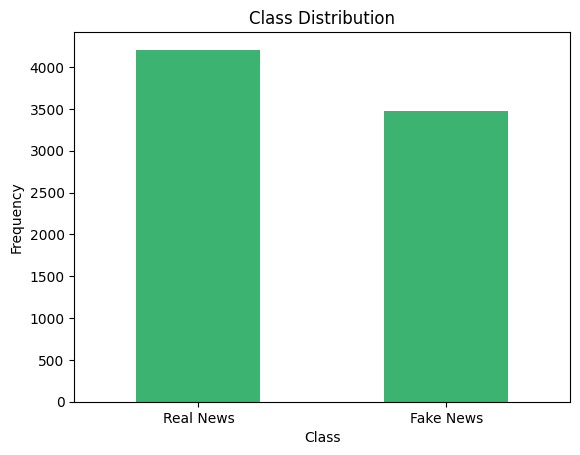

In [26]:
# Evaluate class distribution of y_train and y_test

# Plot class distribution
def plot_class_distribution(y):
    y.value_counts().plot(kind='bar', color='mediumseagreen')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(ticks=[0, 1], labels=['Real News', 'Fake News'], rotation=0)
    plt.show()

# Plot class distribution for training and test sets
plot_class_distribution(y_train)
plot_class_distribution(y_test)

# 7. Feature Extraction
This part of the code deals with converting the text data (news articles) into a numerical format that machine learning models can understand. This process is called feature extraction. The specific technique used here is called TF-IDF (Term Frequency-Inverse Document Frequency).

1)tf (term frequency):-which counts the number of time a particular words is repearting in a documents.

2)idf (inverse document frequency):-Measure the word is a rare word or common word in a document

In [27]:
vectorization = TfidfVectorizer(max_features=10000,ngram_range=(1,2))
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

In [28]:
print("Vocabulary size:", len(vectorization.vocabulary_))


Vocabulary size: 10000


# 8. Model Training & Evaluation

In [29]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


### 8.1 Logistic Regression:
A supervised machine learning algorithm
widely used for binary classification tasks.Logistic regression is used to
predict the categorical dependent variable. It's used when the prediction is categorical, for example, yes or no, true or false, 0 or 1.

This code performs a systematic search for the best hyperparameters for a Logistic Regression model using cross-validation, trains the model with those parameters, and then evaluates its performance on unseen test data. This process helps to find a model that generalizes well to new data and provides a reliable estimate of its accuracy.

In [30]:
# Initialize and train Logistic Regression Model
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(xv_train, y_train)
print(f"Best Parameters for Logistic Regression: {grid_search.best_params_}")

#Train the model with the best parameters
best_lr = grid_search.best_estimator_

# Evaluate on the test data
pred_lr = best_lr.predict(xv_test)
print("Logistic Regression with Best Parameters - Accuracy:", best_lr.score(xv_test, y_test))


Best Parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression with Best Parameters - Accuracy: 0.978795368804475



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4208
           1       0.98      0.97      0.98      3479

    accuracy                           0.98      7687
   macro avg       0.98      0.98      0.98      7687
weighted avg       0.98      0.98      0.98      7687



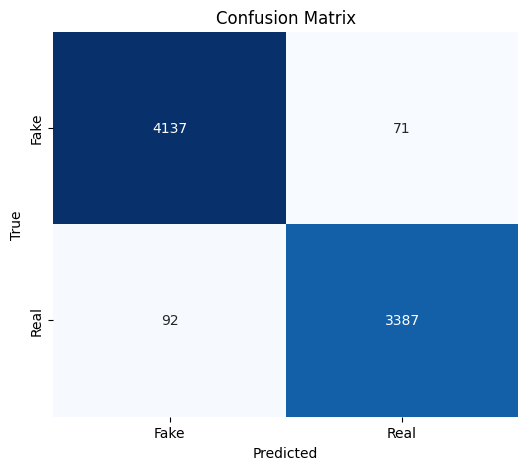

In [31]:
# CLassification report and plot confusion matrix
print("\nLogistic Regression Classification Report:")
print (classification_report(y_test, pred_lr))
cm = metrics.confusion_matrix(y_test, pred_lr)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])


In [32]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg, xv_test, y_test, cv=5)
print(f"Cross-validated scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()} ± {cv_scores.std()}")

Cross-validated scores: [0.95513654 0.9603381  0.95120364 0.95836044 0.95445673]
Mean accuracy: 0.9558990924343016 ± 0.003177173856635974


## 8.2 Random Forest
 A machine learning technique that uses a collection of decision trees to solve problems like classification and regression:
The algorithm creates many decision trees, each trained with a different random noise. The output of the random forest is the class or value that most of the trees select.

In [33]:
# Define the parameter grid for Random Forest
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}

#Initialize Random Forest Model
Rand_for = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(Rand_for, param_grid, cv=5, scoring='accuracy', n_jobs=-1)  # Use n_jobs=-1 for parallel processing
grid_search.fit(xv_train, y_train)  # Use the vectorized training data

# Print the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model with the best parameters
best_rf = grid_search.best_estimator_

# Evaluate on the test data
pred_rf = best_rf.predict(xv_test)
print("Random Forest with Best Parameters - Accuracy:", best_rf.score(xv_test, y_test))


Best Parameters: {'max_depth': 15, 'n_estimators': 200}
Random Forest with Best Parameters - Accuracy: 0.9279302718876025



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4208
           1       0.98      0.86      0.92      3479

    accuracy                           0.93      7687
   macro avg       0.94      0.92      0.93      7687
weighted avg       0.93      0.93      0.93      7687



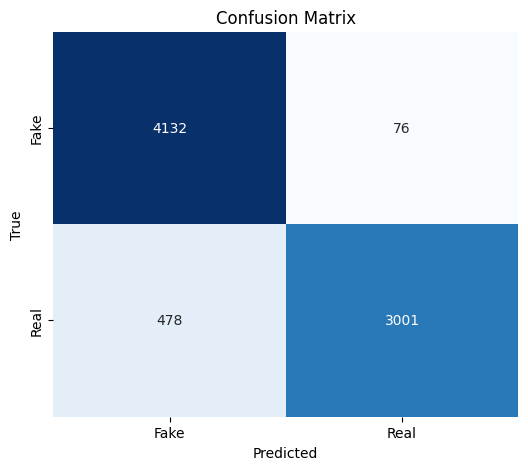

In [34]:
# Classification report and plot confusion matrix
print("\nRandom Forest Classification Report:")
print (classification_report(y_test, pred_rf))
cm = metrics.confusion_matrix(y_test, pred_rf)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [35]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(Rand_for, xv_test, y_test, cv=5)
print(f"Cross-validated scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()} ± {cv_scores.std()}")

Cross-validated scores: [0.95058518 0.95318596 0.94925179 0.95705921 0.95055303]
Mean accuracy: 0.9521270304318362 ± 0.0027773909231992985


# 8.3 Naive Bayes
The Naïve Bayes algorithm is a probabilistic machine learning method used for text classification and multiple class labeling problems. It learns the probability of each object's features and group, then uses predictions to identify the acceptable class.

In [36]:
# Define the parameter grid for MultinomialNB
param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10]}

#Initializing Naive Bayes model
Naive_bay = MultinomialNB()

# Set up GridSearchCV
grid_search = GridSearchCV(Naive_bay, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(xv_train, y_train)  # Use vectorized training data

# Print the best parameters
print(f"Best Parameters for Naive Bayes: {grid_search.best_params_}")

# Train the model with the best parameters
best_naive_bay = grid_search.best_estimator_

# Evaluate on the test data
pred_nb = best_naive_bay.predict(xv_test)
print("Naive Bayes with Best Parameters - Accuracy:", best_naive_bay.score(xv_test, y_test))


Best Parameters for Naive Bayes: {'alpha': 0.01}
Naive Bayes with Best Parameters - Accuracy: 0.9387277221282685



Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4208
           1       0.93      0.94      0.93      3479

    accuracy                           0.94      7687
   macro avg       0.94      0.94      0.94      7687
weighted avg       0.94      0.94      0.94      7687



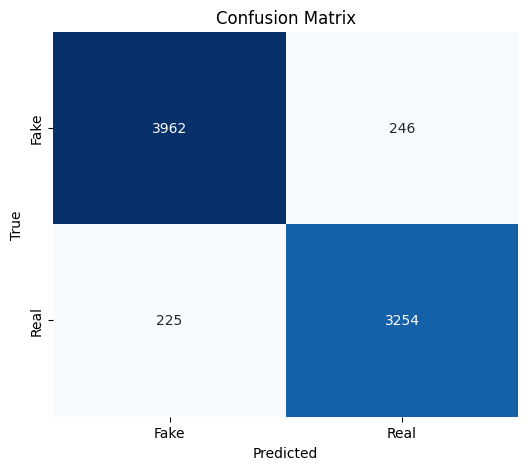

In [37]:
# CLassification report and plot confusion matrix
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, pred_nb))
cm = metrics.confusion_matrix(y_test, pred_nb)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [38]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(Naive_bay, xv_test, y_test, cv=5)
print(f"Cross-validated scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()} ± {cv_scores.std()}")

Cross-validated scores: [0.92587776 0.92912874 0.91607027 0.91932336 0.92257645]
Mean accuracy: 0.9225953147037149 ± 0.004620441748675951


# 8.4 LSTM
LSTM stands for Long Short-Term Memory. It's a special kind of recurrent neural network (RNN) LSTM networks are a powerful tool for text analysis and classification. They are well-suited for fake news detection because they can understand the relationships between words within a text sequence.Here I am  using a Bidirectional LSTM, offering an advantage for capturing these relationships effectively.

In [39]:
# Preparing data for LSTM
max_words = 10000
max_len = 150
embedding_dim = 50
epochs = 5
batch_size = 32

# Prepare data for LSTM with Dropout, Regularization, and Class Weight
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracy_scores = []
history_list = []   # Store training history for each fold

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

In [40]:

for train_index, val_index in kf.split(X):
    print(f"Training Fold {fold_no}...")

    # Split data into train and validation sets
    X_train_fold = X.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_train_fold = y.iloc[train_index]
    y_val_fold = y.iloc[val_index]

    # Reset index to ensure continuous range for y_train_fold and y_val_fold
    y_train_fold = y_train_fold.reset_index(drop=True)
    y_val_fold = y_val_fold.reset_index(drop=True)

    # Tokenization and Padding
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_fold)

    X_train_seq = tokenizer.texts_to_sequences(X_train_fold)
    X_val_seq = tokenizer.texts_to_sequences(X_val_fold)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

    # Define the LSTM model with Dropout and Regularization
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01),
                           recurrent_regularizer=l2(0.01))),
        Dropout(0.5),
        LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
# Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train with class weights
    history = model.fit(X_train_pad, y_train_fold, epochs=epochs, batch_size=batch_size,
              validation_data=(X_val_pad, y_val_fold),
              class_weight=class_weight_dict, verbose=1)
    history_list.append(history)

    # Evaluate the model
    val_preds = (model.predict(X_val_pad) > 0.5).astype(int)
    val_accuracy = accuracy_score(y_val_fold, val_preds)
    accuracy_scores.append(val_accuracy)

    print(f"Fold {fold_no} Accuracy: {val_accuracy}")
    fold_no += 1
model.summary()

Training Fold 1...
Epoch 1/5
961/961 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.5355 - loss: 1.5458 - val_accuracy: 0.4595 - val_loss: 0.6937
Epoch 2/5
961/961 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.5012 - loss: 0.6930 - val_accuracy: 0.4595 - val_loss: 0.6932
Epoch 3/5
961/961 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.4950 - loss: 0.6931 - val_accuracy: 0.5405 - val_loss: 0.6930
Epoch 4/5
961/961 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.5296 - loss: 0.6924 - val_accuracy: 0.5405 - val_loss: 0.6927
Epoch 5/5
961/961 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5106 - loss: 0.6932 - val_accuracy: 0.5405 - val_loss: 0.6925
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Fold 1 Accuracy: 0.5405229608429817
Training Fold 2...
Epoch 1/5
961/961 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.8371 - loss: 1.2537 - val_accuracy: 0.9697 - val_loss: 0.1462
Epoch 2/5
961/961 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9791 - loss: 0.1290 - val_accuracy: 0.9591 -

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 150, 50)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 150, 128)            │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 150, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,744,997 (6.66 MB)

 Trainable params: 581,665 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,163,332 (4.44 MB)

In [41]:
# Calculate and display the mean accuracy across folds
print(f"\nMean Validation Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")


Mean Validation Accuracy: 0.8824 ± 0.1711


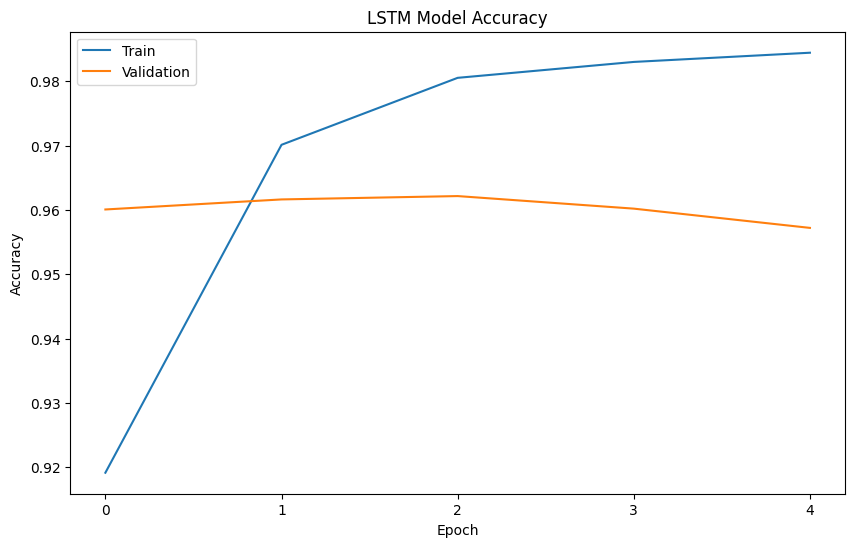

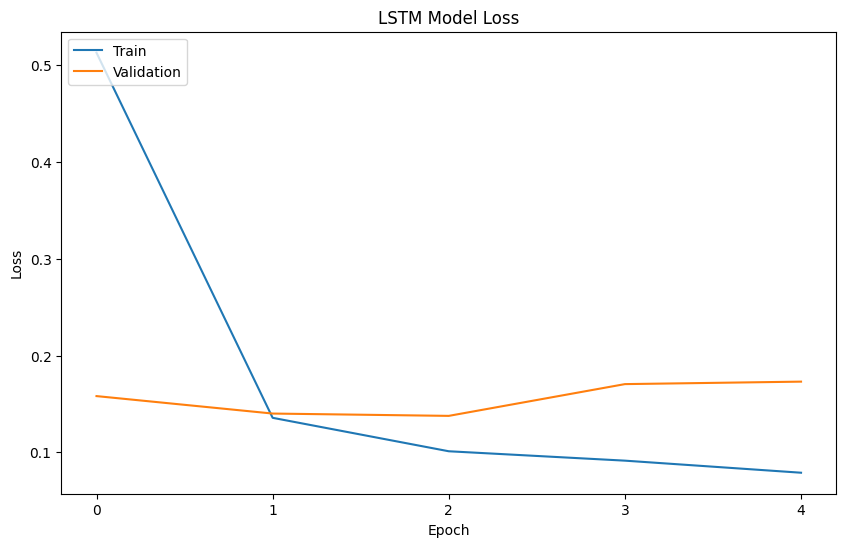

In [42]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Convert x-axis ticks to integers
epochs_range = np.arange(len(history.history['accuracy'])) # Create integer range for epochs
plt.xticks(epochs_range, epochs_range)  # Set x-axis ticks to integer values

plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

epochs_range = np.arange(len(history.history['loss']))  # Create integer range for epochs
plt.xticks(epochs_range, epochs_range)  # Set x-axis ticks to integer values

plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Result Comparison
Here I am plotting the results of all these models Logistic Regression,Random Forest,Naive Bayes and BiLSTM for comparing result

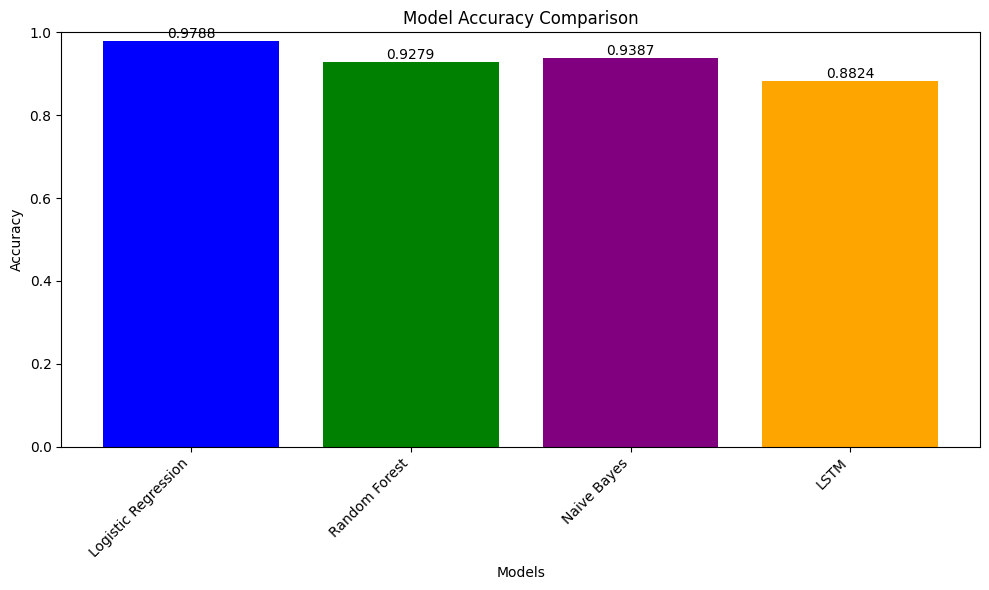

In [46]:
# Model names for the plot
model_names = ['Logistic Regression',  'Random Forest', 'Naive Bayes', 'LSTM']
accuracy_lr = best_lr.score(xv_test, y_test)
accuracy_rf = best_rf.score(xv_test, y_test)
accuracy_nb = best_naive_bay.score(xv_test, y_test)
accuracy_lstm = np.mean(accuracy_scores)

# Accuracy scores for each model
accuracies = [accuracy_lr, accuracy_rf, accuracy_nb, accuracy_lstm]  # Use mean accuracy for LSTM from cross-validation

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'green', 'purple', 'orange'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)  # Set y-axis limits to 0-1 for accuracy
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Add accuracy scores on top of each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()

# Model Testing with Manual Entry

In [49]:
def output_lable(n):
    if n==0:
        return "True News"
    elif n==1:
        return "Fake News"

# Define the wordopt function using your analyze_preprocessing logic
def wordopt(text):
    return analyze_preprocessing(text)['Cleaned Text']


def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test['text'] = new_def_test["text"].apply(wordopt) # preprocessing
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)# feature extraction into numerical features

  # Fit the models before making predictions within the function
    log_reg.fit(xv_train, y_train) # Fit Logistic Regression
    Rand_for.fit(xv_train, y_train) # Fit Random Forest
    Naive_bay.fit(xv_train, y_train) # Fit Naive Bayes

    # Preprocess for LSTM
    new_x_test_seq = tokenizer.texts_to_sequences(new_x_test)  # Tokenize
    new_x_test_pad = pad_sequences(new_x_test_seq, maxlen=max_len) # Pad

    pred_lstm = (model.predict(new_x_test_pad) > 0.5).astype(int)  # Predict using LSTM
    pred_lr = log_reg.predict(new_xv_test)# model prediction
    pred_rf = Rand_for.predict(new_xv_test)
    pred_nb = Naive_bay.predict(new_xv_test)


    return print("\n\nLR Predicition: {}  \nRF Prediction: {}  \nNB Prediction:{} \nLSTM Prediction:{}".format(output_lable(pred_lr[0]),
                                                                                                               output_lable(pred_rf[0]),
                                                                                                               output_lable(pred_nb[0]),
                                                                                                               output_lable(pred_lstm[0])))

In [52]:
news = str(input())
manual_testing(news)


Title: "Government Plans to Implant Microchips in All Citizens by 2025!" Summary: A viral article published on an obscure website claimed that the government has secretly passed a bill requiring all citizens to be implanted with microchips by 2025. According to the report, the microchips will track people's movements, monitor their bank transactions, and enforce "complete control" over their lives. The article includes unverified quotes attributed to unnamed "insiders" and a blurry, manipulated image of a supposed government document.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


LR Predicition: Fake News  
RF Prediction: Fake News  
NB Prediction:Fake News 
LSTM Prediction:Fake News


In [51]:
news = str(input())
manual_testing(news)


Israel pounds Syrian army bases, denies deeper incursionDAMASCUS, Dec 10 (Reuters) - Israel pounded Syrian army bases on Tuesday in strikes it says aim to keep weapons from falling into hostile hands, but denied its forces had advanced into Syria beyond a buffer zone at the border. In the Syrian capital, banks reopened for the first time since the overthrow of President Bashar al-Assad, in a major step towards restoring normal life. Shops were reopening, traffic returned to the roads, construction workers were back fixing a roundabout in the city centre and street cleaners were out sweeping the streets.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


LR Predicition: True News  
RF Prediction: True News  
NB Prediction:True News 
LSTM Prediction:True News
